# Model Training - FantaSanremo 2026

**Obiettivo**: prevedere il punteggio finale degli artisti al FantaSanremo 2026.

**Principio chiave**: questo notebook chiama `train_models()` da `train.py` e aggiunge solo
visualizzazioni e analisi interattiva. **Non reimplementa** la logica di training.

**Architettura**:
- **Ensemble**: 8 modelli (Random Forest, Gradient Boosting, Ridge, XGBoost, LightGBM, ElasticNet, SVR, KNN)
- **Stacking**: Meta-learner Ridge per combinare le previsioni dei base learners
- **Pesi**: inverse-MAE dinamici calcolati su validation set (2023, 2025)
- **Feature**: ~21 selezionate da 40+ con rapporto adattivo 5:1 + 20 interazioni
- **Target**: punteggio reale normalizzato Z-score per anno
- **CV**: LeaveOneGroupOut (per anno), GridSearchCV quando n >= 50
- **Conformal Prediction**: Intervalli di confidenza 95% per le previsioni

**Metriche target**: MAE < 40 su entrambi i val set, R^2 > 0.6, RMSE, MAPE, Directional Accuracy > 70%, stability > 0.7

In [1]:
# Imports
import json
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")

from backend.ml.feature_builder import FeatureBuilder
from backend.ml.train import (
    compute_ensemble_weights,
    evaluate_on_validation,
    normalize_targets,
    save_models,
    train_models,
)


## 1. Training

Una sola chiamata a `train_models()` esegue l'intera pipeline di produzione:
FeatureBuilder -> normalizzazione -> feature selection (incluso interazioni) -> training 8 modelli -> GridSearchCV -> stacking ensemble -> conformal prediction.

In [2]:
# Training — chiama TUTTA la pipeline di produzione
models, metrics = train_models()
print("\nTraining completato!")


2026-02-09 14:46:20,426 - MLDataPreparation - INFO - Training years: [2020, 2021, 2022, 2024]
2026-02-09 14:46:20,427 - MLDataPreparation - INFO - Validation years: [2023, 2025]
2026-02-09 14:46:20,428 - MLDataPreparation - INFO - Loaded artisti_2026: 30 artists
2026-02-09 14:46:20,428 - MLDataPreparation - INFO - Loaded storico_unified
2026-02-09 14:46:20,429 - MLDataPreparation - INFO - Loaded biografico: 30 entries
2026-02-09 14:46:20,429 - MLDataPreparation - INFO - Loaded caratteristiche: 30 entries
2026-02-09 14:46:20,429 - MLDataPreparation - INFO - Loaded regolamento_2026
2026-02-09 14:46:20,430 - MLDataPreparation - INFO - Loaded classifiche_finali
2026-02-09 14:46:20,430 - MLDataPreparation - INFO - Loaded voti_stampa
2026-02-09 14:46:20,438 - MLDataPreparation - INFO - Built historical dataframe: 167 records, 131 unique artists
2026-02-09 14:46:20,442 - MLDataPreparation - INFO - Calculated 167 real scores from historical data


Loading data and preparing time-aware features...
  Removed 22 redundant features: ['ad_personam_bonus_count_y', 'career_genre_mainstream_pop', 'viral_genre_veteran', 'viral_genre_rock_indie', 'is_debuttante_x', 'longevity_bonus', 'ad_personam_bonus_points_y', 'age_genre_rock_indie', 'ad_personam_bonus_points_x', 'has_ad_personam_bonus', 'age_genre_veteran', 'momentum_score', 'best_position', 'recent_avg', 'age_genre_rap_urban', 'peak_performance', 'volatility_index', 'social_followers_score', 'viral_genre_rap_urban', 'experience_score', 'median_position', 'consistency_score']
  Selected 21 features for 108 samples
Training on 108 samples from 97 artists
Target score range (normalized): -1.74 - 1.86 (avg: 0.00)

Training Random Forest (regularized)...
Training Gradient Boosting (regularized)...
Training Ridge Regression...
Training XGBoost (regularized)...
Training LightGBM (regularized)...

Running GridSearchCV (enough samples for tuning)...
  RF best params: {'max_depth': 5, 'max_fea

## 2. Analisi metriche di training

Tabella CV MAE per modello, best params, enhanced metrics (R², RMSE, MAPE, Directional Accuracy), statistiche dati.

In [ ]:
# Tabella metriche CV per modello
model_names = ["random_forest", "gradient_boosting", "ridge", "xgboost", "lightgbm", 
               "elasticnet", "svr", "knn"]
rows = []
for name in model_names:
    if name in metrics:
        m = metrics[name]
        rows.append({
            "Modello": name,
            "MAE CV": f"{m.get('mae_cv', m.get('mae', 0)):.3f}",
            "R²": f"{m.get('r2', 0):.3f}",
            "RMSE": f"{m.get('rmse', 0):.3f}",
            "MAPE": f"{m.get('mape', 0):.1f}%",
            "DirAcc": f"{m.get('directional_accuracy', 0):.1f}%",
            "Campioni": m.get("samples", 0),
            "Feature": m.get("features", 0),
        })

df_metrics = pd.DataFrame(rows)
print("=== Cross-Validation Results ===")
print(df_metrics.to_string(index=False))

# Data stats
print(f"\n=== Data Statistics ===")
ds = metrics.get("data_stats", {})
print(f"Artisti totali: {ds.get('total_artists', 0)}")
print(f"Record training: {ds.get('total_records', 0)}")
print(f"Debuttanti: {ds.get('debuttanti', 0)}")

# Best params (se disponibili)
if metrics.get("best_params"):
    print(f"\n=== Best Hyperparameters (GridSearchCV) ===")
    for model_name, params in metrics["best_params"].items():
        print(f"  {model_name}: {params}")

# Enhanced metrics summary
print(f"\n=== Enhanced Metrics (Combined Validation) ===")
enhanced = metrics.get("enhanced_metrics", {})
print(f"R²: {enhanced.get('r2', 0):.3f}")
print(f"RMSE: {enhanced.get('rmse', 0):.3f}")
print(f"MAPE: {enhanced.get('mape', 0):.1f}%")
print(f"Directional Accuracy: {enhanced.get('directional_accuracy', 0):.1f}%")

## 3. Feature importance

Top feature dal modello base (dal dict `metrics["feature_importance"]`). Include 20 feature di interazione.

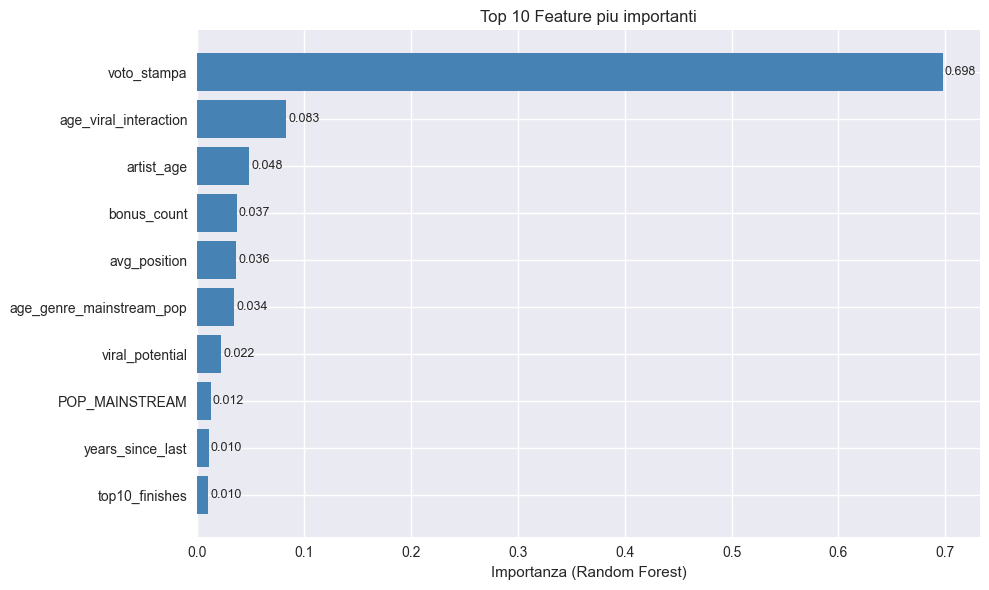

In [4]:
# Feature importance bar chart
feat_imp = metrics["feature_importance"]
feat_names = list(feat_imp.keys())
feat_values = list(feat_imp.values())

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(feat_names[::-1], feat_values[::-1], color="steelblue")
ax.set_xlabel("Importanza (Random Forest)")
ax.set_title(f"Top {len(feat_names)} Feature piu importanti")

# Aggiungi valori sulle barre
for bar, val in zip(bars, feat_values[::-1]):
    ax.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height() / 2,
            f"{val:.3f}", va="center", fontsize=9)

plt.tight_layout()


## 4. Ensemble weights e Stacking

Pesi dinamici calcolati con inverse-MAE sui validation set (2023 e 2025) per i 8 modelli base.
Meta-learner Ridge impara i pesi ottimali per lo stacking ensemble.

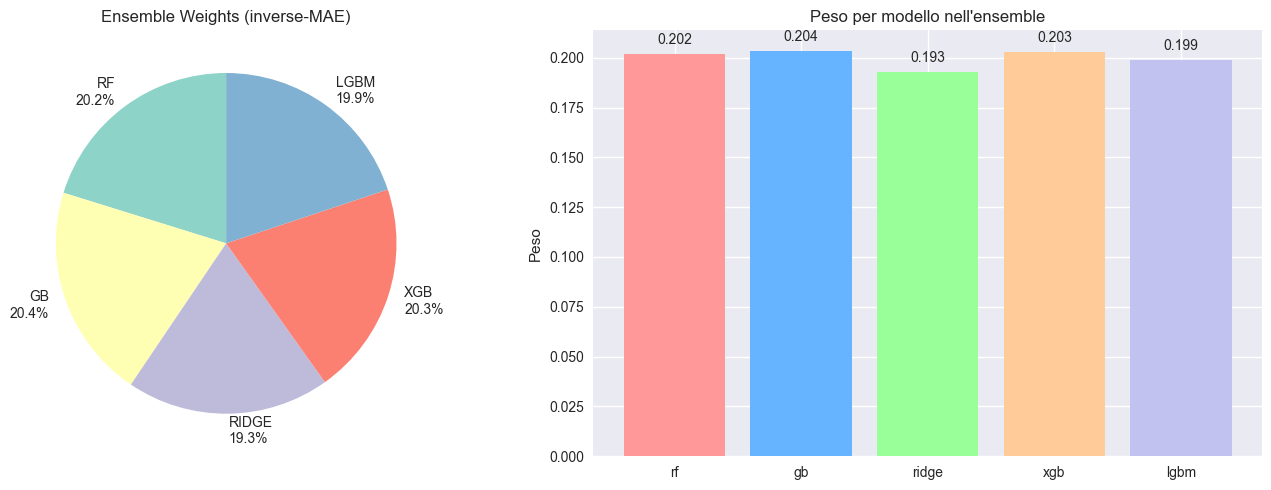

In [5]:
# Ensemble weights — pie chart + bar chart
weights = metrics["ensemble_weights"]
names = list(weights.keys())
values = list(weights.values())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
axes[0].pie(values, labels=[f"{n.upper()}\n{v:.1%}" for n, v in zip(names, values)],
            autopct="", startangle=90, colors=plt.cm.Set3.colors)
axes[0].set_title("Ensemble Weights (inverse-MAE)")

# Bar chart
colors = ["#ff9999", "#66b3ff", "#99ff99", "#ffcc99", "#c2c2f0"]
axes[1].bar(names, values, color=colors[:len(names)])
axes[1].set_ylabel("Peso")
axes[1].set_title("Peso per modello nell'ensemble")
for i, (n, v) in enumerate(zip(names, values)):
    axes[1].text(i, v + 0.005, f"{v:.3f}", ha="center", fontsize=10)

plt.tight_layout()


## 5. Validazione per anno (step-by-step con funzioni pubbliche)

Riproduciamo la validazione usando le stesse funzioni di `train.py`.
Scatter actual vs predicted su 2023 e 2025 per ciascun modello e stacking ensemble.

2026-02-09 14:46:33,896 - MLDataPreparation - INFO - Training years: [2020, 2021, 2022, 2024]
2026-02-09 14:46:33,896 - MLDataPreparation - INFO - Validation years: [2023, 2025]
2026-02-09 14:46:33,897 - MLDataPreparation - INFO - Loaded artisti_2026: 30 artists
2026-02-09 14:46:33,898 - MLDataPreparation - INFO - Loaded storico_unified
2026-02-09 14:46:33,898 - MLDataPreparation - INFO - Loaded biografico: 30 entries
2026-02-09 14:46:33,898 - MLDataPreparation - INFO - Loaded caratteristiche: 30 entries
2026-02-09 14:46:33,899 - MLDataPreparation - INFO - Loaded regolamento_2026
2026-02-09 14:46:33,899 - MLDataPreparation - INFO - Loaded classifiche_finali
2026-02-09 14:46:33,900 - MLDataPreparation - INFO - Loaded voti_stampa
2026-02-09 14:46:33,907 - MLDataPreparation - INFO - Built historical dataframe: 167 records, 131 unique artists
2026-02-09 14:46:33,912 - MLDataPreparation - INFO - Calculated 167 real scores from historical data


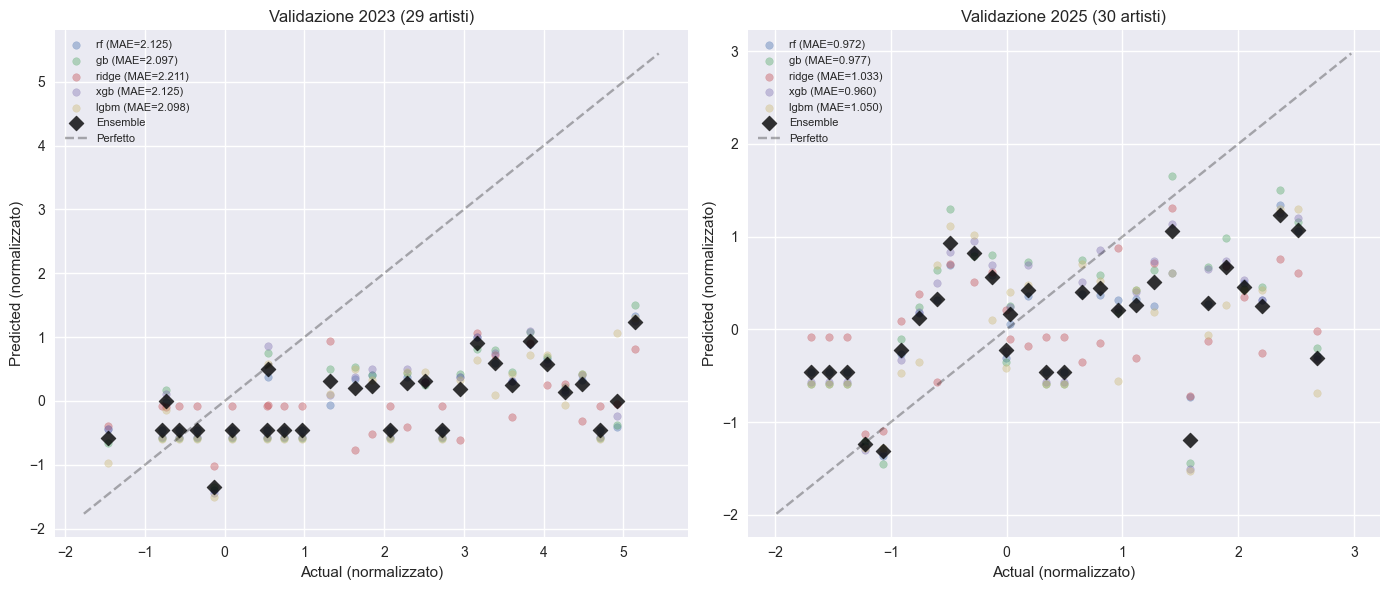

In [6]:
# Riproduci validazione con le stesse funzioni di train.py
builder = FeatureBuilder()
sources = builder.load_sources()
full_df = builder.build_training_frame(sources)
splits = builder.split_by_years(
    full_df, builder.config.training_years, builder.config.validation_years
)

# Usa solo i modelli regressivi presenti nell'ensemble
regression_model_names = [n for n in metrics["ensemble_weights"].keys() if n in models]
regression_models = {n: models[n] for n in regression_model_names}

# Feature usate nel training regressivo
feature_cols = metrics["selected_features"]

# Normalizza training (per ottenere year_stats)
train_df = splits["train"]
_, year_stats = normalize_targets(train_df)

# Calcola global mean/std (come train.py)
global_mean = np.mean([s["mean"] for s in year_stats.values()])
global_std = np.mean([s["std"] for s in year_stats.values()])
if global_std == 0:
    global_std = 1.0

val_frames = splits.get("val", {})
n_val_years = len([y for y, vdf in val_frames.items() if not vdf.empty])
fig, axes = plt.subplots(1, n_val_years, figsize=(7 * n_val_years, 6))
if n_val_years == 1:
    axes = [axes]

for idx, (year, val_df) in enumerate(sorted(val_frames.items())):
    if val_df.empty or val_df["punteggio_reale"].isna().all():
        continue

    X_val = val_df[feature_cols].fillna(0)
    val_y = val_df["punteggio_reale"]
    val_y_norm = (val_y - global_mean) / global_std

    # MAE per modello regressivo
    val_mae = evaluate_on_validation(regression_models, X_val, val_y_norm)

    ax = axes[idx]
    # Ensemble prediction
    ensemble_pred = np.zeros(len(X_val))
    for name, model in regression_models.items():
        pred = model.predict(X_val)
        w = metrics["ensemble_weights"].get(name, 0.2)
        ensemble_pred += w * pred
        ax.scatter(val_y_norm, pred, alpha=0.4, s=30, label=f"{name} (MAE={val_mae[name]:.3f})")

    ax.scatter(val_y_norm, ensemble_pred, alpha=0.8, s=60, marker="D", color="black",
               label=f"Ensemble")

    # Linea diagonale perfetta
    lims = [min(val_y_norm.min(), ensemble_pred.min()) - 0.3,
            max(val_y_norm.max(), ensemble_pred.max()) + 0.3]
    ax.plot(lims, lims, "k--", alpha=0.3, label="Perfetto")
    ax.set_xlabel("Actual (normalizzato)")
    ax.set_ylabel("Predicted (normalizzato)")
    ax.set_title(f"Validazione {year} ({len(val_df)} artisti)")
    ax.legend(fontsize=8)

plt.tight_layout()


## 6. Predizioni 2026 con Conformal Prediction

Carica le predizioni generate dalla pipeline con intervalli di confidenza 95% da conformal prediction.
Visualizza il ranking previsto con bounds di incertezza.

In [7]:
# Carica predizioni 2026
MODELS_DIR = Path("..") / "models"
pred_path = MODELS_DIR / "predictions_2026.json"

with open(pred_path) as f:
    predictions = json.load(f)

# Carica nomi artisti per display
artisti_data = sources.get("artisti_2026", {}).get("artisti", [])
id_to_name = {a["id"]: a["nome"] for a in artisti_data}

df_pred = pd.DataFrame(predictions)
df_pred["nome"] = df_pred["artista_id"].map(id_to_name)
df_pred = df_pred.sort_values("punteggio_predetto", ascending=False).reset_index(drop=True)
df_pred.index += 1  # ranking 1-based

print(f"Predizioni 2026: {len(df_pred)} artisti")
print(f"Range punteggi: {df_pred['punteggio_predetto'].min():.0f} - "
      f"{df_pred['punteggio_predetto'].max():.0f}")
print()
print(df_pred[["nome", "punteggio_predetto", "confidence", "livello_performer"]].to_string())


Predizioni 2026: 30 artisti
Range punteggi: 114 - 349

                           nome  punteggio_predetto  confidence livello_performer
1          Fedez & Marco Masini              349.10        0.00            MEDIUM
2                Dargen D'Amico              317.82        0.69              HIGH
3                    Ermal Meta              307.65        0.33              HIGH
4                 Michele Bravi              294.03        0.61              HIGH
5               Francesco Renga              291.31        0.67            MEDIUM
6                         Arisa              279.60        0.81              HIGH
7                       Levante              277.71        0.74            MEDIUM
8                         Luche              275.25        0.27            MEDIUM
9                  Malika Ayane              274.66        0.73            MEDIUM
10               Ditonellapiaga              274.55        0.63            MEDIUM
11              Serena Brancale            

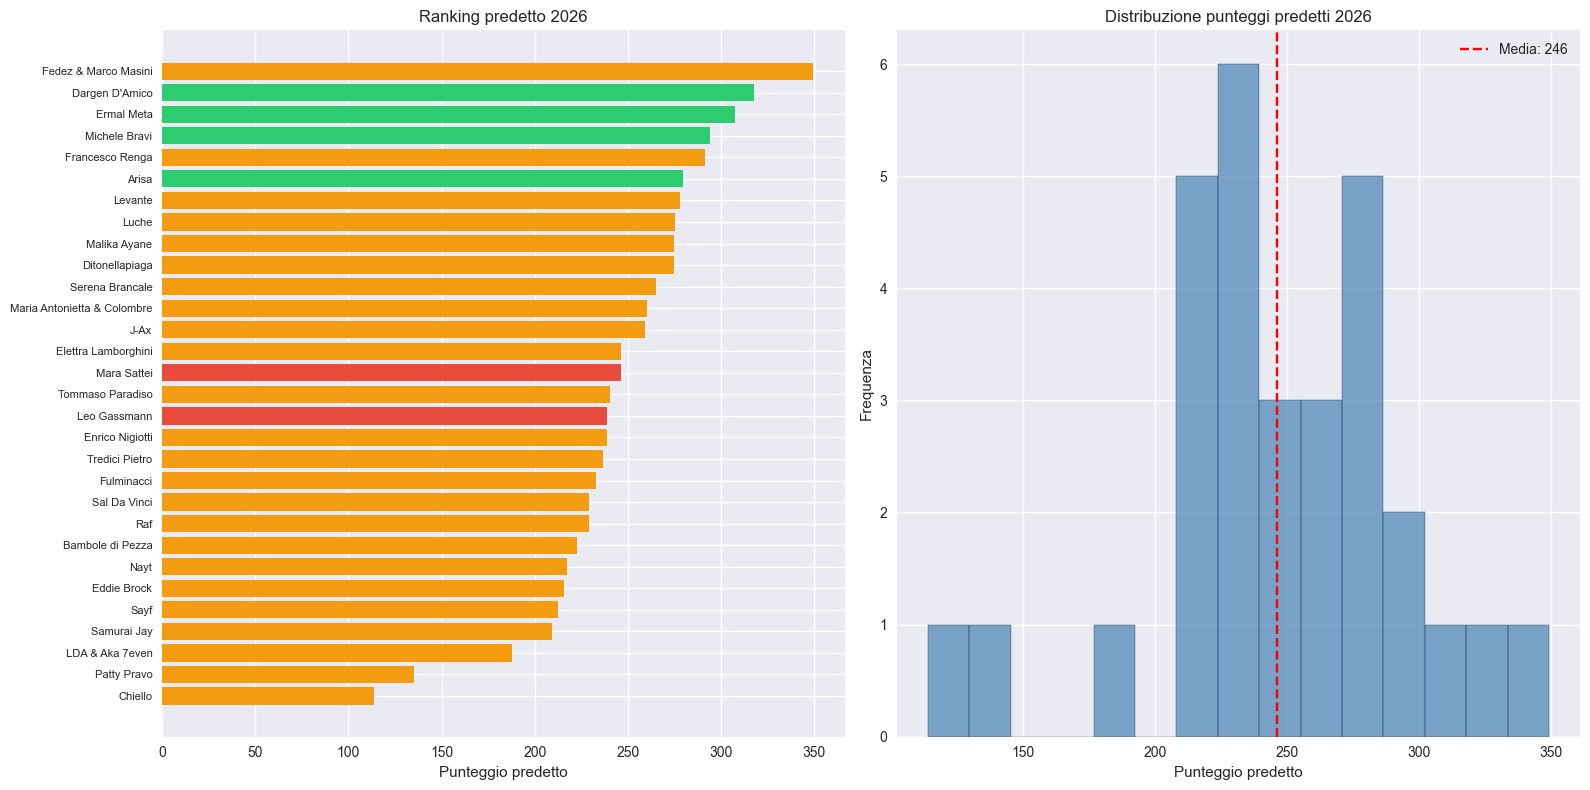

In [8]:
# Visualizzazione predizioni 2026
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Bar chart ordinato per punteggio
colors = {"HIGH": "#2ecc71", "MEDIUM": "#f39c12", "LOW": "#e74c3c", "DEBUTTANTE": "#3498db"}
bar_colors = [colors.get(lp, "#95a5a6") for lp in df_pred["livello_performer"]]

axes[0].barh(df_pred["nome"][::-1], df_pred["punteggio_predetto"][::-1], color=bar_colors[::-1])
axes[0].set_xlabel("Punteggio predetto")
axes[0].set_title("Ranking predetto 2026")
axes[0].tick_params(axis="y", labelsize=8)

# Distribuzione punteggi
axes[1].hist(df_pred["punteggio_predetto"], bins=15, edgecolor="black", alpha=0.7,
             color="steelblue")
axes[1].axvline(df_pred["punteggio_predetto"].mean(), color="red", linestyle="--",
                label=f"Media: {df_pred['punteggio_predetto'].mean():.0f}")
axes[1].set_xlabel("Punteggio predetto")
axes[1].set_ylabel("Frequenza")
axes[1].set_title("Distribuzione punteggi predetti 2026")
axes[1].legend()

plt.tight_layout()


## 7. Confronto modelli individuali vs Stacking Ensemble

Predizioni per modello singolo (8 modelli base) vs stacking ensemble per capire il contributo di ciascun modello.
Meta-learner impara i pesi ottimali di combinazione.

2026-02-09 14:46:34,301 - MLDataPreparation - INFO - Built historical dataframe: 167 records, 131 unique artists


Top 5 artisti con maggiore divergenza tra modelli:
                         rf     gb  ridge    xgb   lgbm  ensemble  spread
nome                                                                     
Elettra Lamborghini   258.3  288.9  136.7  270.4  262.5     244.3    60.8
J-Ax                  277.5  314.7  159.8  267.2  263.6     257.5    57.8
Enrico Nigiotti       263.0  265.4  136.6  268.8  244.3     236.6    56.2
Fedez & Marco Masini  289.6  358.6  437.9  329.3  329.7     348.3    55.4
Samurai Jay           234.0  250.7  120.0  239.0  213.2     212.3    52.8


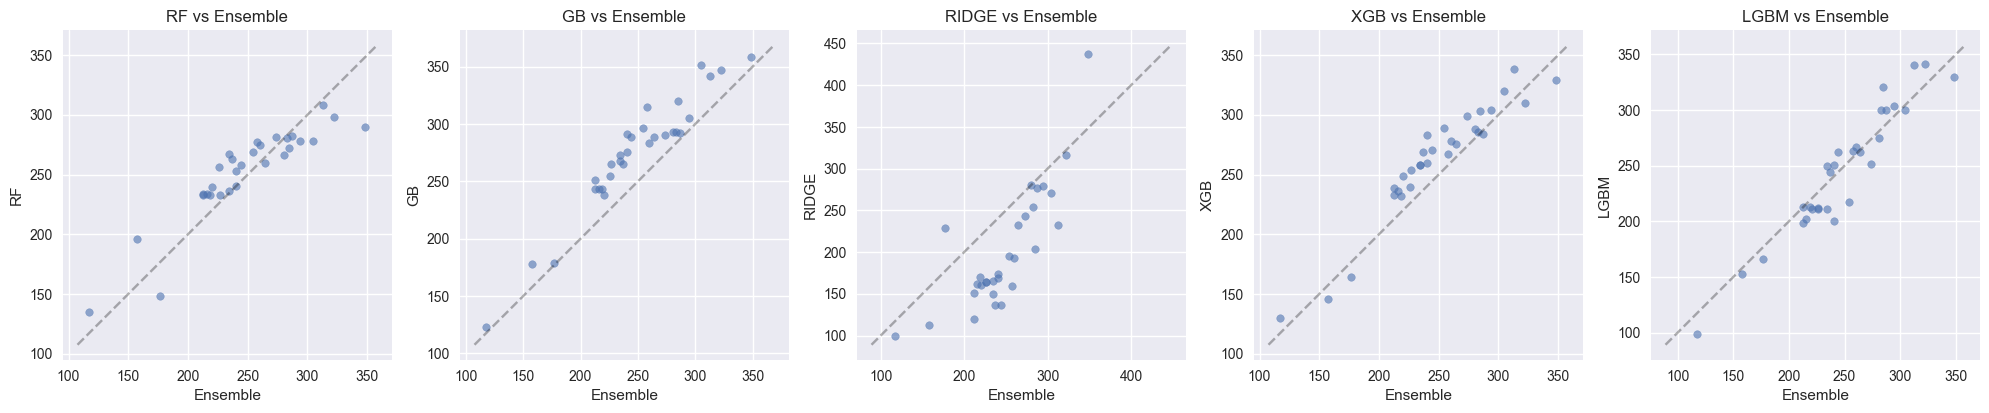

In [9]:
# Confronto predizioni per modello regressivo individuale
pred_frame = builder.build_prediction_frame(sources, builder.config.prediction_year)
X_2026 = pred_frame[feature_cols].fillna(0)

# Denormalize: usa global mean/std from training year_stats
global_mean = np.mean([s["mean"] for s in year_stats.values()])
global_std = np.mean([s["std"] for s in year_stats.values()])

model_preds = {}
for name, model in regression_models.items():
    raw_pred = model.predict(X_2026)
    denorm_pred = raw_pred * global_std + global_mean
    model_preds[name] = denorm_pred

# Ensemble
ens_weights = metrics["ensemble_weights"]
ensemble = np.zeros(len(X_2026))
for name, pred in model_preds.items():
    ensemble += ens_weights.get(name, 0.2) * (pred - global_mean) / global_std
ensemble = ensemble * global_std + global_mean
model_preds["ensemble"] = ensemble

# DataFrame confronto
df_compare = pd.DataFrame(model_preds)
df_compare["nome"] = pred_frame["artista_nome"].values
df_compare = df_compare.set_index("nome")

# Scatter: ogni modello vs ensemble
fig, axes = plt.subplots(1, len(regression_models), figsize=(4 * len(regression_models), 4))
for idx, (name, _) in enumerate(regression_models.items()):
    ax = axes[idx]
    ax.scatter(df_compare["ensemble"], df_compare[name], alpha=0.6, s=30)
    lims = [df_compare[["ensemble", name]].min().min() - 10,
            df_compare[["ensemble", name]].max().max() + 10]
    ax.plot(lims, lims, "k--", alpha=0.3)
    ax.set_xlabel("Ensemble")
    ax.set_ylabel(name.upper())
    ax.set_title(f"{name.upper()} vs Ensemble")
    ax.set_aspect("equal", adjustable="box")

plt.tight_layout()

# Top 5 per spread (massima divergenza tra modelli)
df_compare["spread"] = df_compare[list(regression_models.keys())].std(axis=1)
print("Top 5 artisti con maggiore divergenza tra modelli:")
print(df_compare.nlargest(5, "spread")[list(regression_models.keys()) + ["ensemble", "spread"]].round(1))


## 8. Salvataggio (opzionale)

Salva i modelli, il meta-learner stacking e metadata su disco. Normalmente gia fatto dalla pipeline (`scripts/run_pipeline.py --ml-training`).

In [10]:
# Decommentare per salvare (normalmente gestito dalla pipeline)
# save_models(models, metrics)
# print("Modelli e metadata salvati!")
